In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Cityscapes
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from google.colab import drive
drive.mount('/content/drive')


Using PyTorch version: 2.2.1+cu121
Using GPU, device name: Tesla V100-SXM2-16GB
Mounted at /content/drive


In [ ]:
## some model paths for checkpointing
## So downstream cells can pull
kitti_model_path_dice_original = '/content/drive/My Drive/kitti-dice-org.pth'
kitti_model_path_loss_tracker_dice_orginal = '/content/drive/My Drive/kitti1-loss-org.pth'


kitti_model_path_dice = '/content/drive/My Drive/kitti-dice.pth'
kitti_model_path_loss_tracker_dice = '/content/drive/My Drive/kitti1-loss.pth'


kitti_model_path_bce = '/content/drive/My Drive/kitti-bce.pth'
kitti_model_path_loss_tracker_bce = '/content/drive/My Drive/kitti1-loss-bce.pth'

In [ ]:
!git clone https://github.com/krmerchant/jhu_midterm/

Cloning into 'jhu_midterm'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 196 (delta 115), reused 129 (delta 55), pack-reused 0
Receiving objects: 100% (196/196), 25.07 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (115/115), done.


(256, 256)
159
40
159
4
20
20


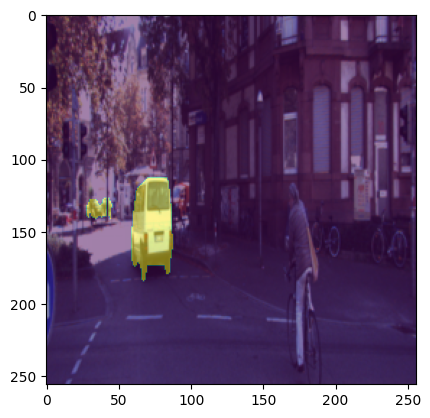

In [ ]:
# @title Inspecting Kitti Dataset

import os
import torch
import pandas as pd
from skimage import io
from torch.utils.data import Dataset
from torchvision import transforms, utils
import torch.nn.functional as F

import sys
sys.path.append('/content/jhu_midterm/src')

from datasets import KittiDataset


kitti = KittiDataset('dataset.csv', '/content/drive/MyDrive/data/kitti_semantic/training',car_only=True,  transform=transforms.Compose([
        transforms.Resize((256, 256))
    ]))

image, seg = kitti[1]
numpy_image = image.permute(1, 2, 0).numpy()
numpy_seg = seg.reshape(seg.shape[1], seg.shape[2]).numpy()
print(numpy_seg.shape)
fig, ax = plt.subplots(1, 1)
ax.imshow((numpy_image))
seg_map = ax.imshow(numpy_seg,alpha=0.5)



## gotta split into sets
## 80% train, 10% val, 10% test
train_size = int(0.8 * len(kitti))
val_size = (len(kitti) - train_size)
test_size = (len(kitti) - train_size)/2
train_dataset, val_dataset = torch.utils.data.random_split(kitti, [train_size, val_size])
print(len(train_dataset))
print(len(val_dataset))


val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [int(test_size), int(test_size)])



# Create data loaders to iterate through the datasets in batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)


print(len(train_loader.sampler))
print(len(train_loader))
print(len(val_loader.sampler))
print(len(test_loader.sampler))



In [ ]:
# @title Training KITTI Standard DICE

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os
from models import UNet
import pickle
from eval_tools import LossTracker


class StandardDICELoss(nn.Module):
    """TODO Put into function"""
    def __init__(self):
        super(StandardDICELoss, self).__init__()
        self.eps = 1e-6

    def forward(self, y_pred, y_true):
        # Flatten the input tensors
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        pos_numerator = (y_pred * y_true).sum()
        pos_demom = y_pred.sum() + y_true.sum()

        neg_numerator = ((1.0 -y_pred) * (1.0 -y_true)).sum()
        neg_demom = (2-y_pred - y_true).sum()

        dice = (pos_numerator/(pos_demom + self.eps)) +  (neg_numerator/(neg_demom + self.eps))

        return 1 - dice


model = UNet(1, debug=False).to(device)

criterion = StandardDICELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.001)  ## set optimizer we're usin
scheduler = ReduceLROnPlateau(optimizer, 'min')
epochs = 300

lt = LossTracker()
best_loss = 1000;
for epoch in range(0,epochs):


  # #TRAINING
  model.train()
  losses = np.array([])
  for i, (images, labels) in (enumerate(train_loader)):
    images = images.to(device)
    labels = labels.to(device).float()
    #forward pass
    pred_labels = model(images.float()).to(device);
    #print(f"{pred_labels=}")
    loss = criterion(pred_labels.to(device), labels.to(device))

    ##optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    losses = np.append(losses,loss.item())
    print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], Train Loss {loss}")

    del images,labels
    if 0:
      fig,ax = plt.subplots(1,3);
      image = images[0,:,:,:].squeeze().permute(1, 2, 0).numpy();
      ax[0].imshow(image)
      ax[1].imshow(labels[0,:,:,:].squeeze());
      seg_im = (pred_labels[0,:,:].detach())
      c =ax[2].imshow(seg_im.squeeze());
      fig.colorbar(c)



  train_loss = np.mean(losses) #average losses over all batches
  lt.add_loss('train',train_loss)


  #VALIDATION
  model.eval()
  total_samples =0;
  correct_samples = 0
  validation_losses = np.array([])
  with torch.no_grad():
    for(images, labels) in val_loader:
      images = images.to(device)
      labels = labels.to(device)
      labels = torch.squeeze(labels)
      outputs = model(images)
      loss = criterion(outputs,labels)
      predicted = outputs.squeeze()>0.5 ##using
      #print(f"{outputs.shape=}")
      #print(f"{labels.shape=}")
      #print(f"{predicted.shape=}")

      total_samples += labels.numel();
      correct_samples += (predicted == labels).sum().item()
      validation_losses = np.append(validation_losses,loss.item())


      del images, outputs,labels



  val_loss = np.mean(validation_losses)
  lt.add_loss('validation',val_loss)
  if(val_loss < best_loss):
    print(' Saving model ...')
    torch.save(model.state_dict(), kitti_model_path_dice_original)
    best_loss = val_loss

  with open(kitti_model_path_loss_tracker_dice_orginal, 'wb') as handle:
    pickle.dump(lt.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
  lr = optimizer.state_dict()["param_groups"][0]["lr"]
  print(f"Epoch [{epoch}/{epochs}], Train Loss {train_loss}, Validation Loss {val_loss}, Accuracy: {correct_samples/total_samples}, LR: {lr}")
  scheduler.step(val_loss)



In [ ]:
# @title Train Model On Kitti Dice Modified

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os
from loss import DICELoss
from models import UNet
import pickle
from eval_tools import LossTracker

model = UNet(1, debug=False).to(device)

criterion = DICELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.001)  ## set optimizer we're usin
scheduler = ReduceLROnPlateau(optimizer, 'min')
epochs = 300

lt = LossTracker()
best_loss = 1000;
for epoch in range(0,epochs):


  # #TRAINING
  model.train()
  losses = np.array([])
  for i, (images, labels) in (enumerate(train_loader)):
    images = images.to(device)
    labels = labels.to(device).float()
    #forward pass
    pred_labels = model(images.float()).to(device);
    #print(f"{pred_labels=}")
    loss = criterion(pred_labels.to(device), labels.to(device))

    ##optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    losses = np.append(losses,loss.item())
    print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], Train Loss {loss}")

    del images,labels
    if 0:
      fig,ax = plt.subplots(1,3);
      image = images[0,:,:,:].squeeze().permute(1, 2, 0).numpy();
      ax[0].imshow(image)
      ax[1].imshow(labels[0,:,:,:].squeeze());
      seg_im = (pred_labels[0,:,:].detach())
      c =ax[2].imshow(seg_im.squeeze());
      fig.colorbar(c)



  train_loss = np.mean(losses) #average losses over all batches
  lt.add_loss('train',train_loss)


  #VALIDATION
  model.eval()
  total_samples =0;
  correct_samples = 0
  validation_losses = np.array([])
  with torch.no_grad():
    for(images, labels) in val_loader:
      images = images.to(device)
      labels = labels.to(device)
      labels = torch.squeeze(labels)
      outputs = model(images)
      loss = criterion(outputs,labels)
      predicted = outputs.squeeze()>0.5 ##using
      print(f"{outputs.shape=}")
      print(f"{labels.shape=}")
      print(f"{predicted.shape=}")

      total_samples += labels.numel();
      correct_samples += (predicted == labels).sum().item()
      validation_losses = np.append(validation_losses,loss.item())


      del images, outputs,labels



  val_loss = np.mean(validation_losses)
  lt.add_loss('validation',val_loss)
  if(val_loss < best_loss):
    print(' Saving model ...')
    torch.save(model.state_dict(), kitti_model_path_dice)
    best_loss = val_loss

  with open(kitti_model_path_loss_tracker_dice, 'wb') as handle:
    pickle.dump(lt.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
  lr = optimizer.state_dict()["param_groups"][0]["lr"]
  print(f"Epoch [{epoch}/{epochs}], Train Loss {train_loss}, Validation Loss {val_loss}, Accuracy: {correct_samples/total_samples}, LR: {lr}")
  scheduler.step(val_loss)



In [ ]:
# @title Train Kitti with BCE Loss

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os
from models import UNet
import pickle
from eval_tools import LossTracker

model = UNet(1, debug=False).to(device)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.001)  ## set optimizer we're usin
scheduler = ReduceLROnPlateau(optimizer, 'min')
epochs = 300

lt = LossTracker()
best_loss = 1000;
for epoch in range(0,epochs):


  # #TRAINING
  model.train()
  losses = np.array([])
  for i, (images, labels) in (enumerate(train_loader)):
    images = images.to(device)
    labels = labels.to(device).float()
    #forward pass
    pred_labels = model(images.float()).to(device);
    #print(f"{pred_labels=}")
    loss = criterion(pred_labels.to(device), labels.to(device))

    ##optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    losses = np.append(losses,loss.item())
    print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], Train Loss {loss}")
    del images,labels, pred_labels



  train_loss = np.mean(losses) #average losses over all batches
  lt.add_loss('train',train_loss)


  #VALIDATION
  model.eval()
  total_samples =0;
  correct_samples = 0
  validation_losses = np.array([])
  with torch.no_grad():
    for(images, labels) in val_loader:
      images = images.to(device)
      labels = labels.to(device).float()
      labels = torch.squeeze(labels)
      outputs = model(images)
      print(f"{outputs.shape=}")
      print(f"{labels.shape=}")

      loss = criterion(outputs.squeeze(),labels)
      predicted = outputs.squeeze()>0.5 ##using
      print(f"{predicted.shape=}")

      total_samples += labels.numel();
      correct_samples += (predicted == labels).sum().item()
      validation_losses = np.append(validation_losses,loss.item())


      del images, outputs,labels



  val_loss = np.mean(validation_losses)
  lt.add_loss('validation',val_loss)
  if(val_loss < best_loss):
    print(' Saving model ...')
    torch.save(model.state_dict(), kitti_model_path_bce)
    best_loss = val_loss

  with open(kitti_model_path_loss_tracker_bce, 'wb') as handle:
    pickle.dump(lt.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
  lr = optimizer.state_dict()["param_groups"][0]["lr"]
  print(f"Epoch [{epoch}/{epochs}], Train Loss {train_loss}, Validation Loss {val_loss}, Accuracy: {correct_samples/total_samples}, LR: {lr}")
  scheduler.step(val_loss)



In [ ]:
del model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

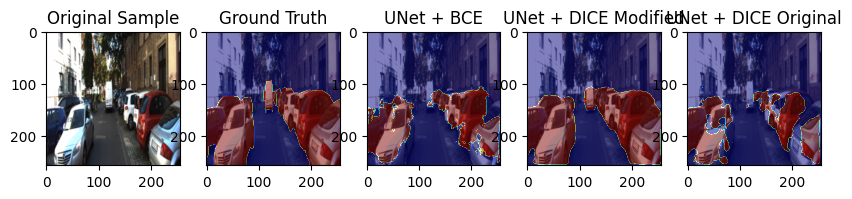

In [ ]:
# @title Qualitative Ground Truth Analysis
from models import UNet
image, seg = test_dataset[9];
[c,w,h] = image.shape
image = image.reshape([1,c,w,h])

bce_model = UNet(1 )
dice_mod_model = UNet(1 )
dice_model = UNet(1 )
bce_model.load_state_dict(torch.load(kitti_model_path_bce, map_location=torch.device('cpu')))
dice_mod_model.load_state_dict(torch.load(kitti_model_path_dice, map_location=torch.device('cpu')))
dice_model.load_state_dict(torch.load(kitti_model_path_dice_original, map_location=torch.device('cpu')))
bce_model.eval()
dice_mod_model.eval()
dice_model.eval()
output_bce = bce_model(image)
output_dice_mod= dice_mod_model(image)
output_dice= dice_model(image)

fig,ax = plt.subplots(1,5, figsize=(10,10));
image = image.squeeze().permute(1, 2, 0).numpy();
ax[0].imshow(image)
ax[0].set_title('Original Sample')

ax[1].imshow(image)
ax[1].imshow(seg.squeeze(), cmap='jet', alpha=0.5);
ax[1].set_title('Ground Truth')


seg_im = output_bce.detach()
ax[2].imshow(image)
ax[2].imshow(seg_im.squeeze()>0.5, cmap='jet', alpha=0.5);
ax[2].set_title('UNet + BCE')

seg_im = output_dice_mod.detach()
ax[3].imshow(image)
ax[3].imshow(seg_im.squeeze()>0.5, cmap='jet', alpha=0.5);
ax[3].set_title('UNet + DICE Modified')


seg_im = output_dice.detach()
ax[4].imshow(image)
ax[4].imshow(seg_im.squeeze()>0.5, cmap='jet', alpha=0.5);
ax[4].set_title('UNet + DICE Original')



plt.savefig('test_sample.png')
from google.colab import files
files.download('test_sample.png')


In [ ]:
# @title Compute Class Imbalance Metric
num_car =0
num_not_car =0
for image,seg in train_dataset:
  num_car +=(seg == 1).sum().item();
  num_not_car +=(seg == 0).sum().item();

print(f"{num_car=}")
print(f"{num_not_car=}")
print(num_car/num_not_car)

num_car=663758
num_not_car=9756466
0.06803262574788863


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

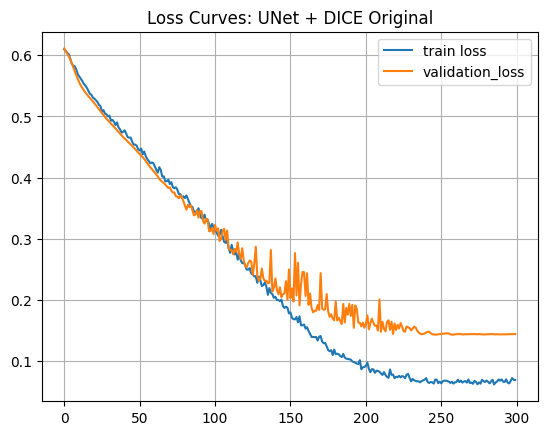

In [ ]:
# @title Plot Training Curves From Kitti Dataset
import pickle
from eval_tools import LossTracker

lt = LossTracker()
with open(kitti_model_path_loss_tracker_dice_orginal, "rb") as myFile:
    myNewPulledInDictionary = pickle.load(myFile)
lt.losses = myNewPulledInDictionary
lt.plot_loss_curves()
plt.title(f"Loss Curves: UNet + DICE Original")

plt.savefig('loss.png')
from google.colab import files
files.download('loss.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

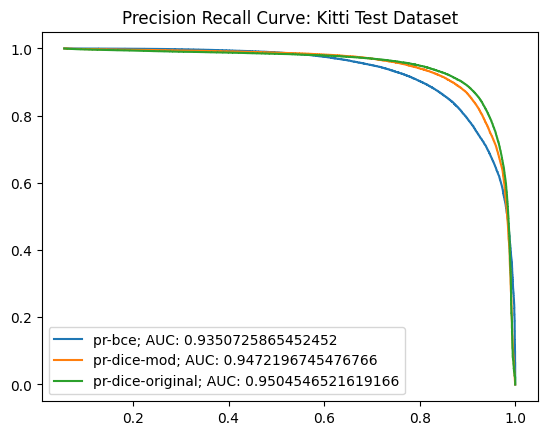

In [ ]:
# @title Generate Ground Truth Statistics

from eval_tools import GroundTruthStatsClass
from models import UNet
import sklearn.metrics as metrics
import torch
bce_model = UNet(1)
bce_model.load_state_dict(torch.load(kitti_model_path_bce, map_location=device))
bce_model.eval()

dice_modified_model = UNet(1)
dice_modified_model.load_state_dict(torch.load(kitti_model_path_dice, map_location=device))
dice_modified_model.eval()

dice_og_model = UNet(1)
dice_og_model.load_state_dict(torch.load(kitti_model_path_dice_original, map_location=device))
dice_og_model.eval()

#bce
gt_bc_test = GroundTruthStatsClass(bce_model, test_dataset)
precision_bce, recall_bce, _ = gt_bc_test.get_pr_numbers()
auc_bce = metrics.auc(recall_bce, precision_bce)

#dice mod
gt_dice_test = GroundTruthStatsClass(dice_modified_model, test_dataset)
precision_dice_mod, recall_dice_mod, _ = gt_dice_test.get_pr_numbers()
auc_dice_mod = metrics.auc(recall_dice_mod, precision_dice_mod)

#original nice
gt_dice_og_test = GroundTruthStatsClass(dice_og_model, test_dataset)
precision_dice_og, recall_dice_og, _ = gt_dice_og_test.get_pr_numbers()
auc_dice_og = metrics.auc(recall_dice_og, precision_dice_og)



fig,ax = plt.subplots();
ax.plot(precision_bce, recall_bce, label=f'pr-bce; AUC: {auc_bce}')
ax.plot(precision_dice_mod, recall_dice_mod, label=f'pr-dice-mod; AUC: {auc_dice_mod}')
ax.plot(precision_dice_og, recall_dice_og, label=f'pr-dice-original; AUC: {auc_dice_og}')

plt.legend()
plt.title('Precision Recall Curve: Kitti Test Dataset')


plt.savefig('pr-curve.png')
from google.colab import files
files.download('pr-curve.png')

In [ ]:
del model